In [1]:
from keypoint_network import build_kpextractor64, build_kpextractor128, preproc_dataset
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'all_kpts_128_fixedx'
dset_loc = 'all_kpts_128_fixedx'

In [3]:
with open(join(dataset_loc, "Flukes/kpts/%s/model.pkl" % model_loc), 'r') as f:
    model = pickle.load(f)

dset = load_dataset(join(dataset_loc, "Flukes/kpts/%s" % dset_loc), normalize_method='zscore')

Loading /home/zach/data/Flukes/kpts/all_kpts_128_fixedx
Took 7.64 seconds


In [4]:
X = T.tensor4()


kpextractor = build_kpextractor128()
ll.set_all_param_values(kpextractor, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(kpextractor)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
kpextractor_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:kpextractor_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(kpextractor)],ll.get_all_params(kpextractor))))

[(0, ((1.0943732, (16, 1, 3, 3)), conv1.W)),
 (1, ((0.45301366, (16,)), conv1.b)),
 (2, ((0.70321304, (16,)), beta)),
 (3, ((0.99797541, (16,)), gamma)),
 (4, ((0.56160313, (16,)), mean)),
 (5, ((49.780445, (16,)), inv_std)),
 (6, ((1.7391628, (32, 16, 3, 3)), conv2.W)),
 (7, ((0.20995378, (32,)), conv2.b)),
 (8, ((0.24178506, (32,)), beta)),
 (9, ((1.1798426, (32,)), gamma)),
 (10, ((0.38867229, (32,)), mean)),
 (11, ((92.993423, (32,)), inv_std)),
 (12, ((2.1383393, (64, 32, 3, 3)), conv3.W)),
 (13, ((0.22832905, (64,)), conv3.b)),
 (14, ((0.34077513, (64,)), beta)),
 (15, ((1.6467834, (64,)), gamma)),
 (16, ((0.35455754, (64,)), mean)),
 (17, ((148.96156, (64,)), inv_std)),
 (18, ((2.9408505, (128, 64, 3, 3)), conv4.W)),
 (19, ((0.27474657, (128,)), conv4.b)),
 (20, ((0.3875716, (128,)), beta)),
 (21, ((2.3213465, (128,)), gamma)),
 (22, ((0.450257, (128,)), mean)),
 (23, ((225.7334, (128,)), inv_std)),
 (24, ((4.1037087, (256, 128, 3, 3)), conv5.W)),
 (25, ((0.29949129, (256,)), co

In [6]:
[(ind, i.shape) for ind, i in enumerate(point_outputs['valid'])]

[(0, (869, 1, 128, 128)),
 (1, (869, 16, 128, 128)),
 (2, (869, 16, 64, 64)),
 (3, (869, 16, 64, 64)),
 (4, (869, 32, 64, 64)),
 (5, (869, 32, 32, 32)),
 (6, (869, 32, 32, 32)),
 (7, (869, 64, 32, 32)),
 (8, (869, 64, 16, 16)),
 (9, (869, 64, 16, 16)),
 (10, (869, 128, 16, 16)),
 (11, (869, 128, 8, 8)),
 (12, (869, 128, 8, 8)),
 (13, (869, 256, 8, 8)),
 (14, (869, 256, 4, 4)),
 (15, (869, 256, 4, 4)),
 (16, (869, 512, 4, 4)),
 (17, (869, 512, 2, 2)),
 (18, (869, 512, 2, 2)),
 (19, (869, 256)),
 (20, (869, 256)),
 (21, (869, 256)),
 (22, (869, 64)),
 (23, (869, 64)),
 (24, (869, 64)),
 (25, (869, 6)),
 (26, (869, 3, 2))]

/home/zach/data/Flukes/Flukebook/images/extractd9f01218-0305-46bb-829b-17af83138e9b.jpg
(407, 960)
[[  45.           9.5390625]
 [ 907.5          9.5390625]
 [ 450.         308.4296875]]
[[   6.    3.]
 [ 121.    3.]
 [  60.   97.]]
[[  36.98638916    1.7859664 ]
 [ 923.16418457    6.84871721]
 [ 463.2097168   287.75042725]]
[[   4.93151855    0.56167984]
 [ 123.08856201    2.15389633]
 [  61.76129532   90.4964447 ]]
[ 11.1502676   15.89354134  24.53830528]
[ 2.66215277  2.253438    6.73783302]


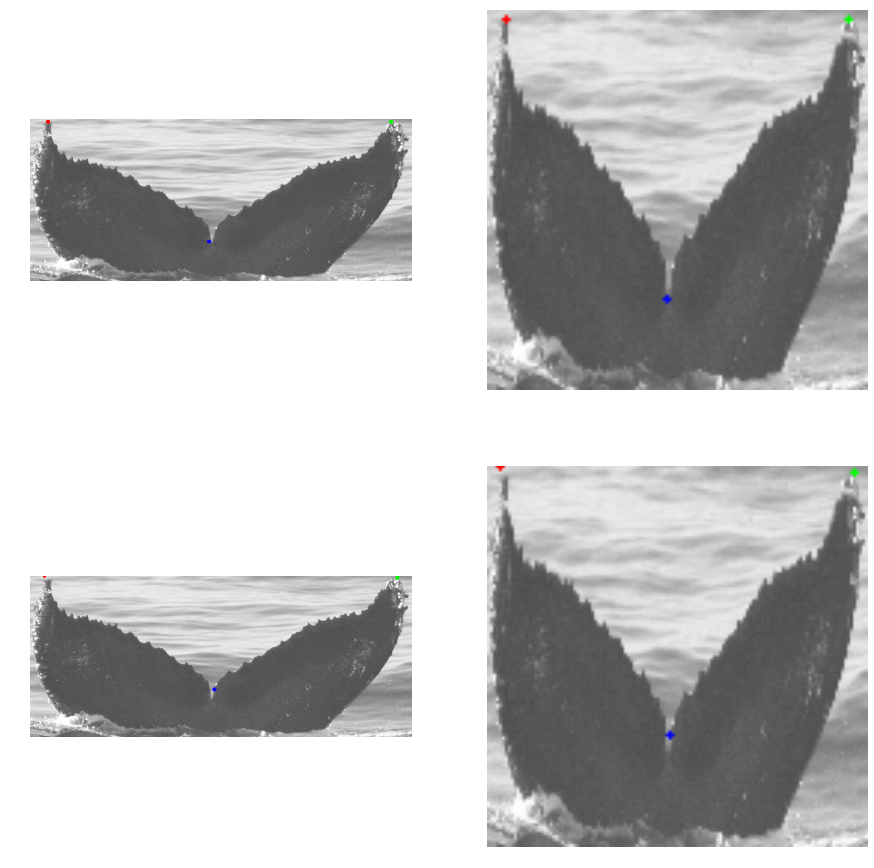

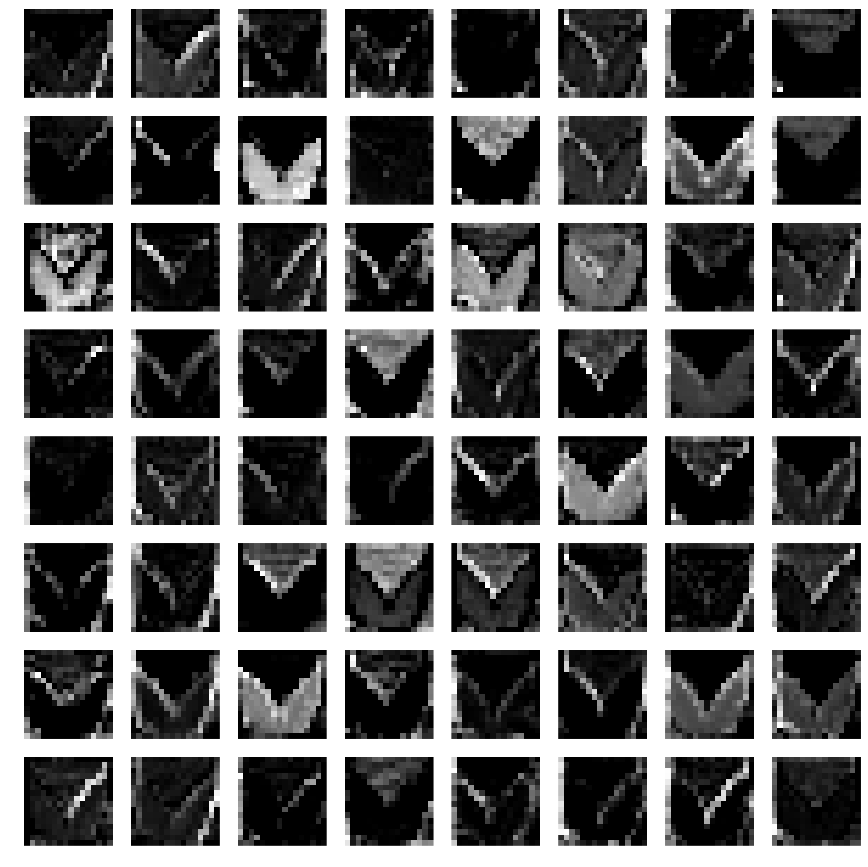

In [7]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def drawPoints(points, img, radius=5):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (int(points[0,0]), int(points[0,1])), radius, (255,0,0), -1) # left
    cv2.circle(color_img, (int(points[1,0]), int(points[1,1])), radius, (0,255,0), -1) # right
    cv2.circle(color_img, (int(points[2,0]), int(points[2,1])), radius, (0,0,255), -1) # notch
    return color_img

def show_output(originals, true_labels, outputs, ind, stage=-1, imgnames=None, sizes=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dsety, dsetx = dset_img.shape[:2]
    true_points = true_labels[ind]
    imgname = imgnames[ind]
    print(imgname)
    original_img = cv2.cvtColor(cv2.imread(imgname),cv2.COLOR_BGR2GRAY)
    if sizes is not None:
        original_img = cv2.resize(original_img, tuple(sizes[ind][::-1]), cv2.INTER_LANCZOS4)
    print(original_img.shape)
    origy, origx = original_img.shape[:2]
    #sizey, sizex = original.shape[-2:]
    sizey, sizex = (1.,1.)
    scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.array([origx, origy]*3,dtype=np.float32).reshape(3,2)
    scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_points * (scale_num_orig / scale_denom)
    true_points_dset = true_points * (scale_num_dset / scale_denom)
    print(true_points_orig)
    print(true_points_dset)
    #true_points_scaled = (true_points * scale_mat + scale_mat) / 2 
    # draw left right notch on the original image
    orig_gt_drawn = drawPoints(true_points_orig, original_img)
    dset_gt_drawn = drawPoints(true_points_dset, dset_img, radius=1)
    
    pred_points = outputs[-1][ind]
    #pred_points_scaled = (pred_points * scale_mat + scale_mat) / 2
    pred_points_orig = pred_points * (scale_num_orig / scale_denom)
    pred_points_dset = pred_points * (scale_num_dset / scale_denom)
    print(pred_points_orig)
    print(pred_points_dset)
    pred_drawn_orig = drawPoints(pred_points_orig, original_img)
    pred_drawn_dset = drawPoints(pred_points_dset, dset_img, radius=1)
    print(np.linalg.norm(true_points_orig - pred_points_orig, axis=1))
    print(np.linalg.norm(true_points_dset - pred_points_dset, axis=1))
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(orig_gt_drawn)
    trueax[0,1].imshow(dset_gt_drawn)
    trueax[1,0].imshow(pred_drawn_orig)
    trueax[1,1].imshow(pred_drawn_dset)
    
    nfilters = network_stage.shape[-1]
    #print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
    for i in range(square_size*square_size):
        #netax.set_gray()
        this_ax = netax[i // square_size, i % square_size]
        this_ax.axis('off')
        #this_ax.get_xaxis().set_visible(False)
        #this_ax.get_yaxis().set_visible(False)
        if i < nfilters:
            this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'valid'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=8, 
            imgnames=dset_for_model[sec]['names'], sizes=dset_for_model[sec]['extra'])

[[ 0.05985688  0.12751727]
 [ 0.92994821  0.12829041]
 [ 0.49307755  0.51545417]]
[[ 0.05297886  0.11136639]
 [ 0.93198687  0.13293479]
 [ 0.49357197  0.51079392]]
0.0341508
0.0863263
0.0900679


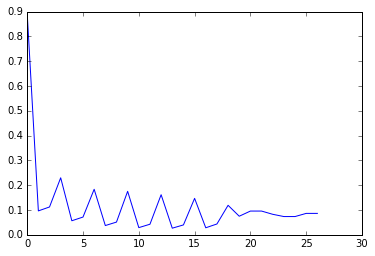

In [8]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])
avg_prediction = np.average(dset_for_model[sec]['y'],axis=0)
print(avg_prediction)
print(np.average(point_outputs[sec][-1],axis=0))
def eucl_loss(pred, y):
    return np.average(np.linalg.norm(pred - y, axis=2),axis=(0,1))

print(eucl_loss(point_outputs[sec][-1], dset_for_model[sec]['y']))
print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

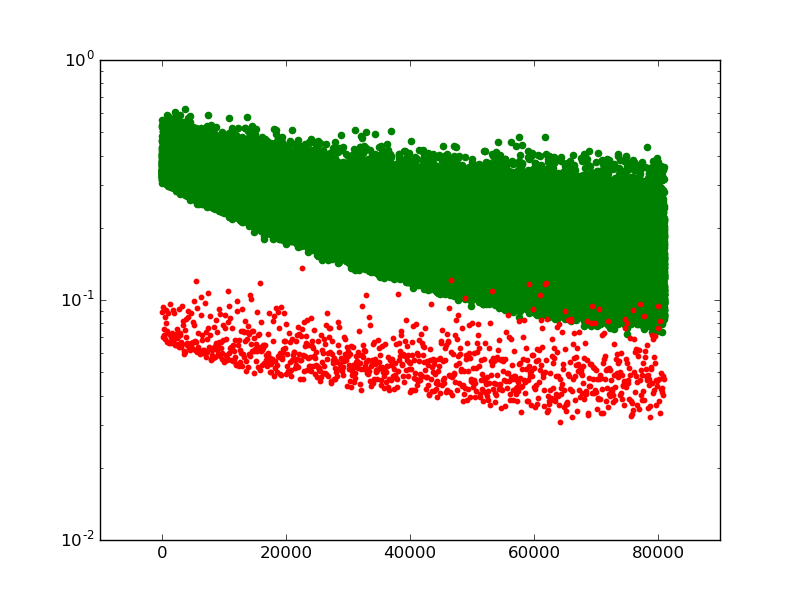

In [9]:
from IPython.display import Image 
Image(filename='./losses.png')

In [55]:
# let's see the worst cases by original size
sec = 'valid'
def get_gt_dist(true_pt, pred_pt, sizes):
    #sizey, sizex = (1.,1.)
    sizes = sizes[:,::-1]
    #scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.stack([sizes, sizes, sizes],axis=1).astype(np.float32)
    #scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_pt * (scale_num_orig)
    #true_points_dset = true_points * (scale_num_dset / scale_denom)
    pred_points_orig = pred_pt * (scale_num_orig)
    dists = np.linalg.norm(true_points_orig - pred_points_orig, axis=2)
    #print(dists)
    return dists

gt_dists = get_gt_dist(dset_for_model[sec]['y'], point_outputs[sec][-1], dset_for_model[sec]['extra'])

In [56]:
sorted_by_dist = sorted(zip(gt_dists, list(range(dset_for_model[sec]['X'].shape[0]))), key=lambda x: np.average(x[0]))
dists, ind_sorted = zip(*sorted_by_dist)
sorted_X = dset_for_model[sec]['X'][ind_sorted,:]
sorted_y = dset_for_model[sec]['y'][ind_sorted,:]
sorted_pred = [stage[ind_sorted,:] for stage in point_outputs[sec]]
sorted_names = [dset_for_model[sec]['names'][ind] for ind in ind_sorted]
sorted_sizes = dset_for_model[sec]['extra'][ind_sorted,:]

/home/zach/data/Flukes/CRC_combined constrained/10135-JAC96-47-04.jpg
(681, 960)
[[  45.         164.9296875]
 [ 922.5        138.328125 ]
 [ 472.5        308.578125 ]]
[[   6.   31.]
 [ 123.   26.]
 [  63.   58.]]
[[ 732.69317627  157.32562256]
 [ 264.01535034  151.74891663]
 [ 469.94561768  326.41854858]]
[[ 97.69242096  29.57074738]
 [ 35.20204544  28.5225563 ]
 [ 62.6594162   61.35326385]]
[ 687.73522949  658.62139893   18.02236366]
[ 91.70355988  87.83419037   3.37051558]


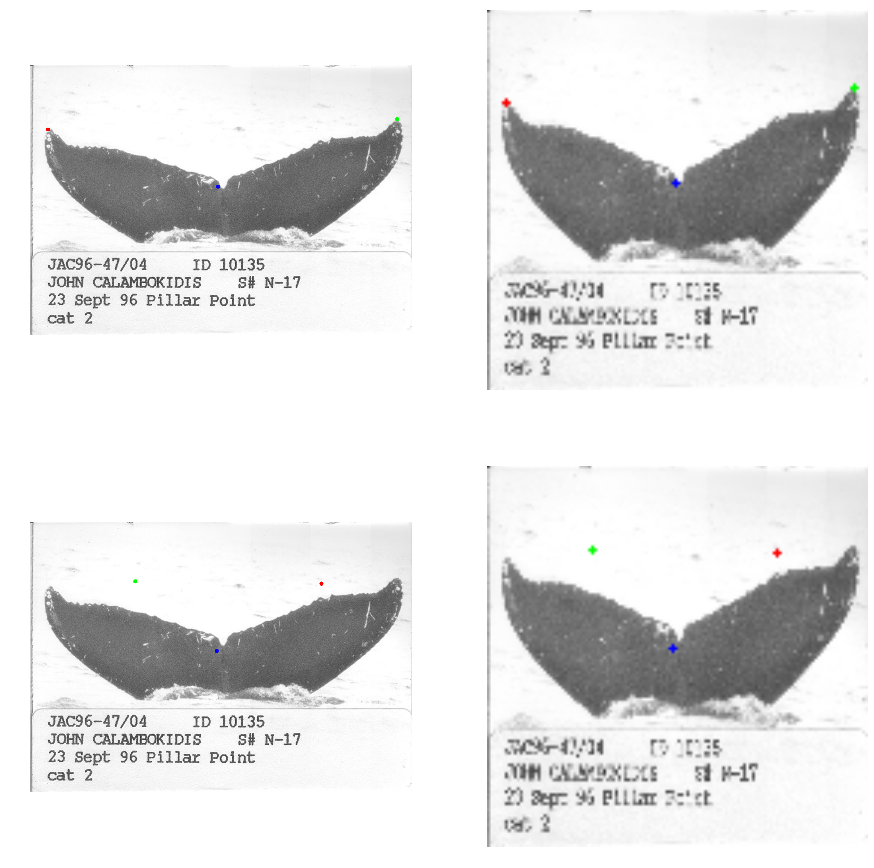

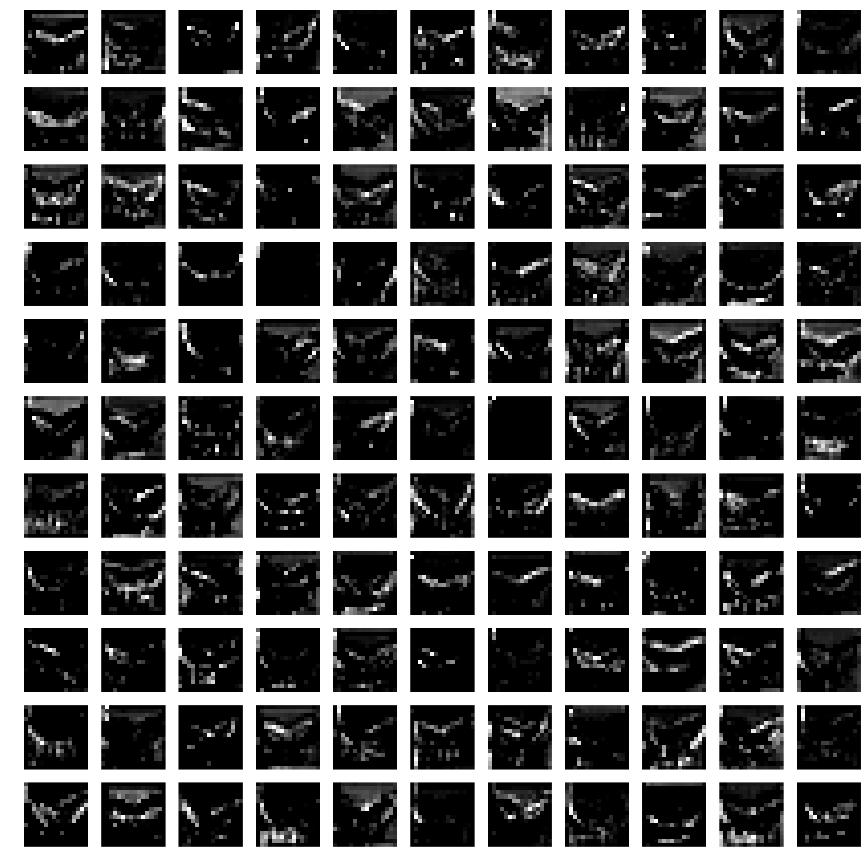

In [59]:
show_output(sorted_X, sorted_y, sorted_pred, -1, stage=10, imgnames=sorted_names, sizes=sorted_sizes)

In [13]:
# Export model params and dataset so that IBEIS can use it
model_ibs = {'params':model, 'mean':dset['mean'], 'std':dset['std']}
model_name = 'kpextractor_weights.pkl'
model_dir = '/home/zach/data'
with open(join(model_dir, model_name), 'w') as f:
    pickle.dump(model_ibs, f)
print(model_ibs['mean'])

148.01371843


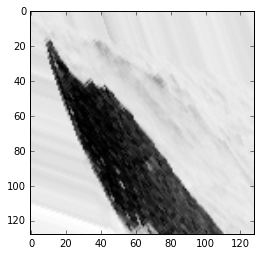

In [75]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))